<a href="https://colab.research.google.com/github/ThisIsFarhan/LangGraph-Practice/blob/main/10_Graph_Node_Stream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq

In [2]:
from google.colab import userdata
from langchain_groq import ChatGroq

groq_api_key=userdata.get('groq_api_key')
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

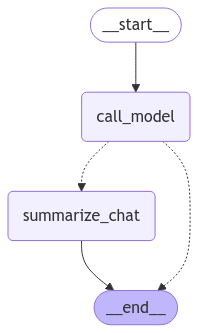

In [3]:
from langgraph.graph import MessagesState
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver

class State(MessagesState):
  summary:str

# Check if the summary exist
def call_model(state:State):
  summary = state.get('summary',"")
  if summary:
    system_msg = f"Summary of conversation earlier: {summary}"
    messages = [SystemMessage(content=system_msg)] + state["messages"]
  else:
    messages = state["messages"]

  response = llm.invoke(messages)
  return {"messages":response}


#Summarization Node
def summarize_chat(state:State):
  summary = state.get("summary","")
  if summary:
    summary_msg = f"This is the summary of the conversation to date: {summary}\nExtend the summary according to the messages above"
  else:
    summary_msg = "Make the summary according to the messages above"

  messages = state["messages"] + [HumanMessage(content=summary_msg)]
  response = llm.invoke(messages)

  delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
  return {"summary":response.content,"messages":delete_messages}

#Conditional Node
def should_summarize(state:State):
  messages = state["messages"]
  if len(messages) > 6:
    return "summarize_chat"
  else:
    return END

builder = StateGraph(State)
builder.add_node(call_model,"call_model")
builder.add_node(summarize_chat,"summarize_chat")

builder.add_edge(START,"call_model")
builder.add_conditional_edges("call_model",should_summarize)
builder.add_edge("summarize_chat",END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable":{"thread_id":1}}

for chunk in graph.stream({"messages":[HumanMessage(content="Hi! I am Farhan")]},config=config,stream_mode="updates"):
  print(chunk)

{'call_model': {'messages': AIMessage(content='Hello Farhan, nice to meet you!\n\nIs there anything I can help you with today? 😊  \n\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 15, 'total_tokens': 41, 'completion_time': 0.047272727, 'prompt_time': 8.983e-05, 'queue_time': 0.020375839, 'total_time': 0.047362557}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-15f082d2-7601-4655-b3a5-18ebbfbc10aa-0', usage_metadata={'input_tokens': 15, 'output_tokens': 26, 'total_tokens': 41})}}


In [7]:
# Start conversation
for chunk in graph.stream({"messages": [HumanMessage(content="hi! I'm Farhan")]}, config, stream_mode="updates"):
    chunk['call_model']["messages"].pretty_print()

================================== Ai Message ==================================

Hi Farhan! 

It's nice to meet you. 😊 What can I do for you today?


In [9]:
# Start conversation, again
config = {"configurable": {"thread_id": "2"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Farhan ali khan")
for event in graph.stream({"messages": [input_message]}, config, stream_mode="values"):
    for m in event['messages']:
        m.pretty_print()
    print("---"*25)

================================ Human Message =================================

hi! I'm Farhan
================================== Ai Message ==================================

Hi Farhan, nice to meet you! 👋

What can I do for you today? 😊
================================ Human Message =================================

hi! I'm Farhan ali khan
---------------------------------------------------------------------------
================================ Human Message =================================

hi! I'm Farhan
================================== Ai Message ==================================

Hi Farhan, nice to meet you! 👋

What can I do for you today? 😊
================================ Human Message =================================

hi! I'm Farhan ali khan
================================== Ai Message ==================================

Hello Farhan Ali Khan, it's a pleasure to meet you!

Is there anything I can help you with today?
------------------------------------------------

In [10]:
config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="Tell me about the foundations of derivatives and integrals")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    print(f"Node: {event['metadata'].get('langgraph_node','')}. Type: {event['event']}. Name: {event['name']}")

Node: . Type: on_chain_start. Name: LangGraph
Node: __start__. Type: on_chain_start. Name: __start__
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_start. Name: _write
Node: __start__. Type: on_chain_end. Name: _write
Node: __start__. Type: on_chain_stream. Name: __start__
Node: __start__. Type: on_chain_end. Name: __start__
Node: call_model. Type: on_chain_start. Name: call_model
Node: call_model. Type: on_chat_model_start. Name: ChatGroq
Node: call_model. Type: on_chat_model_stream. Name: ChatGroq
Node: call_model. Type: on_chat_model_stream. Name: ChatGroq
Node: call_model. Type: on_chat_model_stream. Name: ChatGroq
Node: call_model. Type: on_chat_model_stream. Name: ChatGroq
Node: call_model. Type: on_chat_model_stream. Name: ChatGroq
Node: call_model. Type: on_chat_model_stream. Name: ChatGroq
Node: call_model. Type: on_chat_model_stream. Name: ChatGroq
Node: call_model. Type: on_chat_model_stre

In [11]:
node_to_stream = 'call_model'
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="Tell me about the foundations of derivatives and integrals")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        print(event["data"])

{'chunk': AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run-e3224704-0e8d-433f-bc33-178641de2d40')}
{'chunk': AIMessageChunk(content='##', additional_kwargs={}, response_metadata={}, id='run-e3224704-0e8d-433f-bc33-178641de2d40')}
{'chunk': AIMessageChunk(content=' The', additional_kwargs={}, response_metadata={}, id='run-e3224704-0e8d-433f-bc33-178641de2d40')}
{'chunk': AIMessageChunk(content=' Foundations', additional_kwargs={}, response_metadata={}, id='run-e3224704-0e8d-433f-bc33-178641de2d40')}
{'chunk': AIMessageChunk(content=' of', additional_kwargs={}, response_metadata={}, id='run-e3224704-0e8d-433f-bc33-178641de2d40')}
{'chunk': AIMessageChunk(content=' Derivatives', additional_kwargs={}, response_metadata={}, id='run-e3224704-0e8d-433f-bc33-178641de2d40')}
{'chunk': AIMessageChunk(content=' and', additional_kwargs={}, response_metadata={}, id='run-e3224704-0e8d-433f-bc33-178641de2d40')}
{'chunk': AIMessageChunk(content=' Integrals', additional_kw

In [12]:
config = {"configurable": {"thread_id": "5"}}
input_message = HumanMessage(content="Tell me about the foundations of derivatives and integrals")
async for event in graph.astream_events({"messages": [input_message]}, config, version="v2"):
    # Get chat model tokens from a particular node
    if event["event"] == "on_chat_model_stream" and event['metadata'].get('langgraph_node','') == node_to_stream:
        data = event["data"]
        print(data["chunk"].content, end="|")

|Let|'|s| dive| into| the| fascinating| world| of| derivatives| and| integrals|,| exploring| their| foundational| concepts|:|

|**|Deriv|atives|:| The| Essence| of| Change|**|

|*| **|Instant|aneous| Rate| of| Change|:**|  |At| its| core|,| a| derivative| measures| how| much| a| function|'|s| output| changes| in| response| to| an| infinites|im|ally| small| change| in| its| input|.| Imagine| driving| a| car| –| the| derivative| of| your| position| with| respect| to| time| is| your| instantaneous| speed|.|

|*| **|Slope| of| the| Tang|ent| Line|:**|  |Geometric|ally|,| the| derivative| at| a| point| on| a| curve| represents| the| slope| of| the| line| tangent| to| that| curve| at| that| point|.|  |

|*| **|Limit| Definition|:**|

|   |The| derivative| of| a| function| *|f|(|x|)*| at| a| point| *|x| =| a|*| is| defined| as|:|

|   |```|
|   |f|'(|a|)| =| lim| (|h| ->| |0|)| [|f|(|a| +| h|)| -| f|(|a|)]| /| h| |
|   |```|

|   |This| limit| calculates| the| average| rate| of| change| over|